# Example use case: Zero-age stellar luminosity function in binaries

In this notebook we compute the luminosity function of the zero-age main-sequence by running a population of binary stars using binary_c. 

Before you go through this notebook, you should look at notebook_luminosity_function.ipynb which is for the - conceptually more simple - single stars.

We start by loading in some standard Python modules and the binary_c module.


In [1]:
import os
import math

from binarycpython.utils.grid import Population

# help(Population) # Uncomment this line to see the public functions of this object

## Setting up the Population object
To set up and configure the population object we need to make a new instance of the `Population` object and configure it with the `.set()` function.

In our case, we only need to set the maximum evolution time to something short, because we care only about zero-age main sequence stars which have, by definition, age zero.

In [2]:
# Create population object
population = Population()

# If you want verbosity, set this before other things
population.set(verbosity=1)

# Setting values can be done via .set(<parameter_name>=<value>)
# Values that are known to be binary_c_parameters are loaded into bse_options.
# Those that are present in the default grid_options are set in grid_options
# All other values that you set are put in a custom_options dict
population.set(
    # binary_c physics options
    max_evolution_time=0.1,  # maximum stellar evolution time in Myr. We do this to capture only ZAMS
 )

# We can access the options through 
print("verbosity is", population.grid_options['verbosity'])

verbosity is 1


Now that we have set up the population object, we need to add grid variables to describe the population of stars we want to run. For more information on this see the "notebook_population.ipynb". Here we add three grid variables:
- Primary mass sampled with log sampling
- Mass ratio sampled with linear sampling
- Period sampled with log10 sampling

In [3]:
# resolution on each side of the cube, with more stars for the primary mass
nres = 10
resolution = {
    "M_1": 4 * nres,
    "q": nres,
    "per": nres
}

binwidth = { 'luminosity' : 1.0}

massrange = [0.07, 100]
logperrange = [0.15, 5.5]

population.add_grid_variable(
    name="lnm1",
    longname="Primary mass",
    valuerange=massrange,
    samplerfunc="self.const_linear(math.log({min}), math.log({max}), {res})".format(min=massrange[0],max=massrange[1],res=resolution["M_1"]),
    precode="M_1=math.exp(lnm1)",
    probdist="self.three_part_powerlaw(M_1, 0.1, 0.5, 1.0, 150, -1.3, -2.3, -2.3)*M_1",
    dphasevol="dlnm1",
    parameter_name="M_1",
    condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
)

# Mass ratio
population.add_grid_variable(
     name="q",
     longname="Mass ratio",
     valuerange=["0.1/M_1", 1],
     samplerfunc="self.const_linear({}/M_1, 1, {})".format(massrange[0],resolution['q']),
     probdist="self.flatsections(q, [{{'min': {}/M_1, 'max': 1.0, 'height': 1}}])".format(massrange[0]),
     dphasevol="dq",
     precode="M_2 = q * M_1",
     parameter_name="M_2",
     condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
 )

# Orbital period
population.add_grid_variable(
    name="log10per", # in days
    longname="log10(Orbital_Period)",
    valuerange=[0.15, 5.5],
    samplerfunc="self.const_linear({}, {}, {})".format(logperrange[0],logperrange[1],resolution["per"]),
    precode="""orbital_period = 10.0 ** log10per
sep = calc_sep_from_period(M_1, M_2, orbital_period)
sep_min = calc_sep_from_period(M_1, M_2, 10**{})
sep_max = calc_sep_from_period(M_1, M_2, 10**{})""".format(logperrange[0],logperrange[1]),
    probdist="self.sana12(M_1, M_2, sep, orbital_period, sep_min, sep_max, math.log10(10**{}), math.log10(10**{}), {})".format(logperrange[0],logperrange[1],-0.55),
    parameter_name="orbital_period",
    dphasevol="dlog10per",
 )

## Setting logging and handling the output
By default, binary_c will not output anything (except for 'SINGLE STAR LIFETIME'). It is up to us to determine what will be printed. We can either do that by hardcoding the print statements into `binary_c` (see documentation binary_c) or we can use the custom logging functionality of binarycpython (see notebook `notebook_custom_logging.ipynb`), which is faster to set up and requires no recompilation of binary_c, but is somewhat more limited in its functionality. For our current purposes, it works perfectly well.

After configuring what will be printed, we need to make a function to parse the output. This can be done by setting the parse_function parameter in the population object (see also notebook `notebook_individual_systems.ipynb`). 

In the code below we will set up both the custom logging and a parse function to handle that output.

In [4]:
# Create custom logging statement
#
# we check that the model number is zero, i.e. we're on the first timestep (stars are born on the ZAMS)
# we make sure that the stellar type is <= MAIN_SEQUENCE, i.e. the star is a main-sequence star
# we also check that the time is 0.0 (this is not strictly required, but good to show how it is done)
#
# The 
#
# The Printf statement does the outputting: note that the header string is ZERO_AGE_MAIN_SEQUENCE_STARn
#
# where:
#
# n = PRIMARY    = 0 is star 0 (primary star)
# n = SECONDARY  = 1 is star 1 (secondary star)
# n = UNRESOLVED = 2 is the unresolved system (both stars added)

PRIMARY = 0
SECONDARY = 1
UNRESOLVED = 2

custom_logging_statement = """
// select ZAMS
if(stardata->model.model_number == 0 &&
   stardata->model.time == 0)
{
    // loop over the stars individually (equivalent to a resolved binary) 
    Foreach_star(star)
    {
        // select main-sequence stars
        if(star->stellar_type <= MAIN_SEQUENCE)
        {
            /* Note that we use Printf - with a capital P! */
           Printf("ZERO_AGE_MAIN_SEQUENCE_STAR%d %30.12e %g %g %g %g\\n",
                  star->starnum,
                  stardata->model.time, // 1
                  stardata->common.zero_age.mass[0], // 2
                  star->mass, // 3
                  star->luminosity, // 4
                  stardata->model.probability // 5
           );
        }
    }
    
    // unresolved MS-MS binary
    if(stardata->star[0].stellar_type <= MAIN_SEQUENCE &&
       stardata->star[1].stellar_type <= MAIN_SEQUENCE) 
    {
        Printf("ZERO_AGE_MAIN_SEQUENCE_STAR%d %30.12e %g %g %g %g\\n",
                  2,
                  stardata->model.time, // 1
                  stardata->common.zero_age.mass[0] + stardata->common.zero_age.mass[1], // 2
                  stardata->star[0].mass + stardata->star[1].mass, // 3
                  stardata->star[0].luminosity + stardata->star[1].luminosity, // 4
                  stardata->model.probability // 5
           );
    }
}
"""

population.set(
    C_logging_code=custom_logging_statement
)

adding: C_logging_code=
// select ZAMS
if(stardata->model.model_number == 0 &&
   stardata->model.time == 0)
{
    // loop over the stars individually (equivalent to a resolved binary) 
    Foreach_star(star)
    {
        // select main-sequence stars
        if(star->stellar_type <= MAIN_SEQUENCE)
        {
            /* Note that we use Printf - with a capital P! */
           Printf("ZERO_AGE_MAIN_SEQUENCE_STAR%d %30.12e %g %g %g %g\n",
                  star->starnum,
                  stardata->model.time, // 1
                  stardata->common.zero_age.mass[0], // 2
                  star->mass, // 3
                  star->luminosity, // 4
                  stardata->model.probability // 5
           );
        }
    }
    
    // unresolved MS-MS binary
    if(stardata->star[0].stellar_type <= MAIN_SEQUENCE &&
       stardata->star[1].stellar_type <= MAIN_SEQUENCE) 
    {
        Printf("ZERO_AGE_MAIN_SEQUENCE_STAR%d %30.12e %g %g %g %g\n",
                  2,
             

The parse function must now catch lines that start with "ZERO_AGE_MAIN_SEQUENCE_STAR" and process the associated data.

In [5]:
# import the bin_data function so we can construct finite-resolution probability distributions
# import the datalinedict to make a dictionary from each line of data from binary_c
from binarycpython.utils.functions import bin_data,datalinedict
import re

def parse_function(self, output):
    """
    Example parse function
    """
    
    # list of the data items
    parameters = ["header", "time", "zams_mass", "mass", "luminosity", "probability"]
    
    # Loop over the output.
    for line in output.splitlines():
        
        # check if we match a ZERO_AGE_MAIN_SEQUENCE_STAR
        match = re.search('ZERO_AGE_MAIN_SEQUENCE_STAR(\d)',line) 
        if match:
            nstar = match.group(1) 
            #print("matched star",nstar)

            # obtain the line of data in dictionary form 
            linedata = datalinedict(line,parameters)

            # bin the log10(luminosity) to the nearest 0.1dex
            binned_log_luminosity = bin_data(math.log10(linedata['luminosity']),
                                             binwidth['luminosity'])
            
            # append the data to the results_dictionary 
            self.grid_results['luminosity distribution'][int(nstar)][binned_log_luminosity] += linedata['probability'] 
            
            #print (self.grid_results)
    
    # verbose reporting
    #print("parse out results_dictionary=",self.grid_results)
    
# Add the parsing function
population.set(
    parse_function=parse_function,
)

adding: parse_function=<function parse_function at 0x7f777242c4c0> to grid_options


## Evolving the grid
Now that we configured all the main parts of the population object, we can actually run the population! Doing this is straightforward: `population.evolve()`

This will start up the processing of all the systems. We can control how many cores are used by settings `num_cores`. By setting the `verbosity` of the population object to a higher value we can get a lot of verbose information about the run, but for now we will set it to 0.

There are many grid_options that can lead to different behaviour of the evolution of the grid. Please do have a look at those: [grid options docs](https://ri0005.pages.surrey.ac.uk/binary_c-python/grid_options_descriptions.html), and try  

In [6]:
# set number of threads
population.set(
    # verbose output is not required    
    verbosity=1,

    # set number of threads (i.e. number of CPU cores we use)
    num_cores=4,
)

# Evolve the population - this is the slow, number-crunching step
print("Running the population now, this may take a little while...")
analytics = population.evolve()  
print("Done population run!")

# Show the results (debugging)
# print (population.grid_results)

adding: verbosity=1 to grid_options
adding: num_cores=4 to grid_options
Running the population now, this may take a little while...
Creating and loading custom logging functionality
Do dry run? True
Doing dry run to calculate total starcount and probability
Generating grid code
Save grid code to grid_options
Write grid code to /tmp/binary_c_python-david/binary_c_grid_58bfc73fabfb43b18ae455666fe4d8f8.py [dry_run = True]
Symlinked grid code to /tmp/binary_c_python-david/binary_c_grid-latest0 
Load grid code function from /tmp/binary_c_python-david/binary_c_grid_58bfc73fabfb43b18ae455666fe4d8f8.py
Grid code loaded
Doing a dry run of the grid.
Grid has handled 3159 stars with a total probability of 0.645748
**********************************
*             Dry run            *
*     Total starcount is 3159    *
*  Total probability is 0.645748 *
**********************************

[2022-06-18 12:49:01,996 DEBUG    Process-2] --- Setting up processor: process-0
[2022-06-18 12:49:02,008 DEBUG

After the run is complete, some technical report on the run is returned. I stored that in `analytics`. As we can see below, this dictionary is like a status report of the evolution. Useful for e.g. debugging.

In [9]:
print(analytics)

{'population_id': '58bfc73fabfb43b18ae455666fe4d8f8', 'evolution_type': 'grid', 'failed_count': 0, 'failed_prob': 0, 'failed_systems_error_codes': [], 'errors_exceeded': False, 'errors_found': False, 'total_probability': 0.6457484448453049, 'total_count': 3159, 'start_timestamp': 1655552941.9314468, 'end_timestamp': 1655552946.3461084, 'time_elapsed': 4.414661645889282, 'total_mass_run': 65199.55913120549, 'total_probability_weighted_mass_run': 0.6433998017038131, 'zero_prob_stars_skipped': 0}


[None]

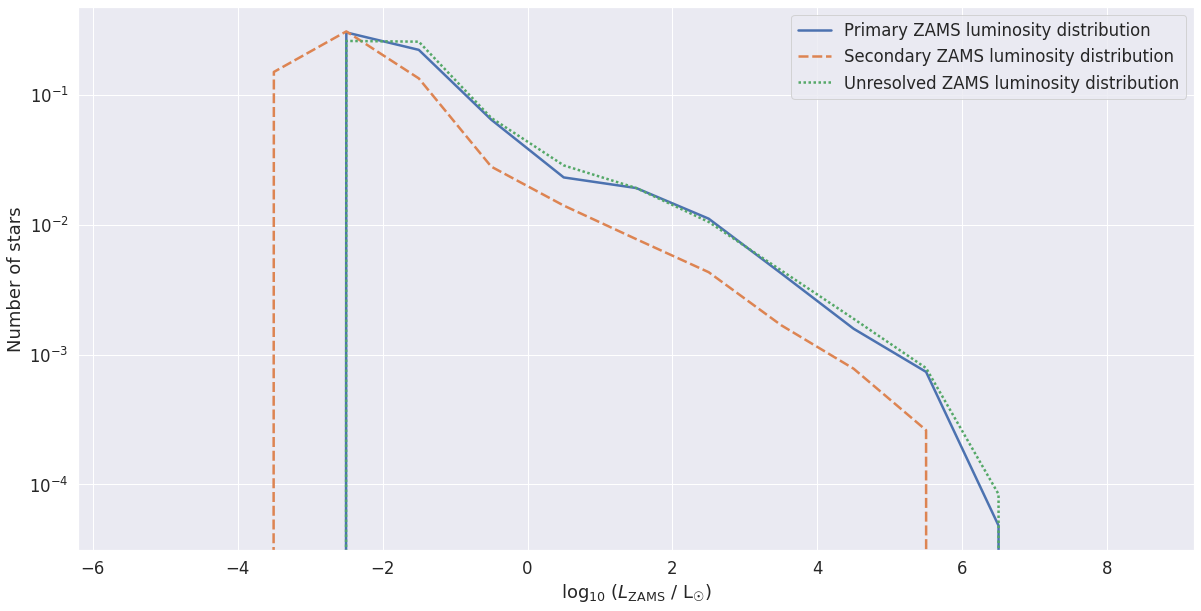

In [10]:
# make a plot of the luminosity distribution using Seaborn and Pandas
import seaborn as sns
import pandas as pd
from binarycpython.utils.functions import pad_output_distribution

# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(20,10)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})


titles = { 0 : "Primary",
           1 : "Secondary",
           2 : "Unresolved" }

# choose to plot the 
# PRIMARY, SECONDARY or UNRESOLVED
nstar = UNRESOLVED

plots = {}

# pad the distribution with zeros where data is missing
for n in range(0,3):
    pad_output_distribution(population.grid_results['luminosity distribution'][n],
                            binwidth['luminosity'])
    plots[titles[n] + ' ZAMS luminosity distribution'] = population.grid_results['luminosity distribution'][n]

# make pandas dataframe from our sorted dictionary of data
plot_data = pd.DataFrame.from_dict(plots)

# make the plot
p = sns.lineplot(data=plot_data)
p.set_xlabel("$\log_{10}$ ($L_\mathrm{ZAMS}$ / L$_{☉}$)")
p.set_ylabel("Number of stars")
p.set(yscale="log")

You can see that the secondary stars are dimmer than the primaries - which you expect given they are lower in mass (by definition q=M2/M1<1). 

Weirdly, in some places the primary distribution may exceed the unresolved distribution. This is a bit unphysical, but in this case is usually caused by limited resolution. If you increase the number of stars in the grid, this problem should go away (at a cost of more CPU time). 

Things to try:

 * Massive stars: can you see the effects of wind mass loss and rejuvenation in these stars?
 * Alter the metallicity, does this make much of a difference?
 * Change the binary fraction. Here we assume a 100% binary fraction, but a real population is a mixture of single and binary stars.
 * How might you go about comparing these computed observations to real stars?
 * What about evolved stars? Here we consider only the *zero-age* main sequence. What about other main-sequence stars? What about stars in later phases of stellar evolution?